# Bank Marketing: Our Data and Approach

The setting and goal of our Dataset was already described:  
  
Setting:  
_"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed."_  

Goal:  
_"The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y)."_  

## Nature of Data
First we looked at the Nature of the Data.  
[Nature of Data](Nature_of_Data_NEW.ipynb)  

Important findings were:  
  
  

## Testing different classification models

As first approach to learning, we tried diferent models.  
[Research Notebook](research.ipynb) with Data processing as well as some different approachaes. 



### Preprocessing
Before we did that however, we started by preprocessing the Data.
First, we imported the Data. There is a smaller Dataset with around 10% included in the Data, that we decided to use for the research process. (So we had more reasonable processing times)

Afterwards, we prepared the Data and encoded it, using a OneHot Encoder as well as a MinMaxScaler.


In [1]:
import pandas as pd
import itertools
import numpy as np
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict

In [2]:
bank_data = pd.read_csv("Data/bank-additional/bank-additional/bank-additional.csv", delimiter=";") #10 % of examples

bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
from sklearn.preprocessing import LabelEncoder

# Preprocessing of the target data
bank_target = bank_data['y']
bank_data = bank_data.drop(columns='y')

label = LabelEncoder()
bank_target = label.fit_transform(bank_target)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'duration', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])
print(bank_target)

[0 0 0 ... 0 0 0]


Pipelines:

In [4]:
# decision tree
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', DecisionTreeClassifier())])

# random forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', RandomForestClassifier())])

# k nearest neighbours
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', KNeighborsClassifier())])

# multinomial naive bayes
mnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', MultinomialNB())])

# gaussian naive bayes
gnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', GaussianNB())])

Grid Search Parameters:

In [5]:
dt_param_grid =  { 'classifier__criterion':['gini','entropy'],
                   'classifier__max_depth': np.arange(3, 15)}

rf_param_grid =  {'classifier__n_estimators': [50, 100, 200],
                  'classifier__max_features': ['sqrt','log2'], 
                  'classifier__max_depth' : [4,5,6,7,8],
                  'classifier__criterion' :['gini', 'entropy']}

knn_param_grid = {'classifier__n_neighbors': [3,5,11,19],
                  'classifier__weights': ['uniform', 'distance'],
                  'classifier__metric': ['euclidean', 'manhattan']}

mnb_param_grid = {'classifier__alpha': [0.5, 1.0, 1.5, 2.0],
                  'classifier__fit_prior': [True, False]}

gnb_param_grid = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}

Plot Confusion Matrix Function(from class):

In [6]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Cost function and Matrix:

| Predict\Actual  | Subscribe (1) | Not Subscribe (0)    |
|-----------------|---------------|----------------------|
| Subscribe (1)   | 120 (Benefit)| 40 (Cost: Marketing) |
| Not Subscribe (0)| 100 (Cost: Lost Deal) | 0 (No Cost)          |

In [7]:
from sklearn.metrics import make_scorer


def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=label_order)    
    return cm[0][0] * 0 + cm[0][1] * 40 - cm[1][1] * 120 + cm[1][0] * 100

scorer = make_scorer(cost_function, greater_is_better=False)

Predict:


Best DecisionTree Classifier with parameters({'classifier__criterion': 'entropy', 'classifier__max_depth': 6}): Accuracy of 0.8555474629764506 and cost -23660


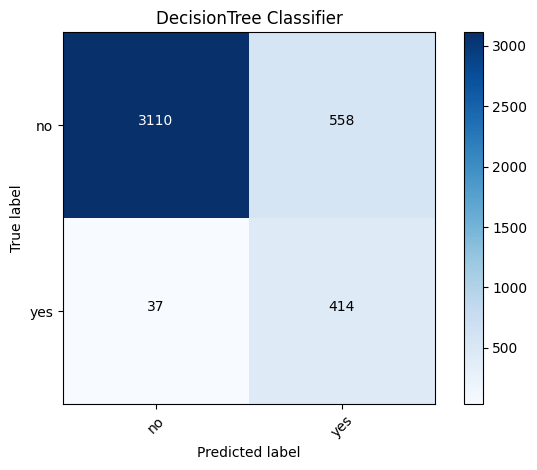

              precision    recall  f1-score   support

          no       0.99      0.85      0.91      3668
         yes       0.43      0.92      0.58       451

    accuracy                           0.86      4119
   macro avg       0.71      0.88      0.75      4119
weighted avg       0.93      0.86      0.88      4119


Best RandomForest Classifier with parameters({'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}): Accuracy of 0.8499635833940277 and cost -26700


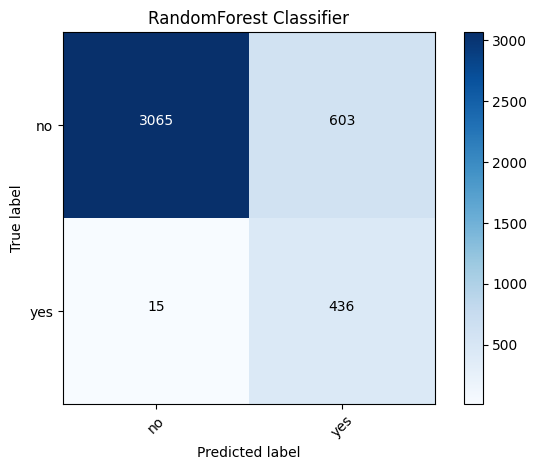

              precision    recall  f1-score   support

          no       1.00      0.84      0.91      3668
         yes       0.42      0.97      0.59       451

    accuracy                           0.85      4119
   macro avg       0.71      0.90      0.75      4119
weighted avg       0.93      0.85      0.87      4119



c:\Users\I568830\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\I568830\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Best KNN Classifier with parameters({'classifier__metric': 'manhattan', 'classifier__n_neighbors': 19, 'classifier__weights': 'uniform'}): Accuracy of 0.8203447438698713 and cost 3380


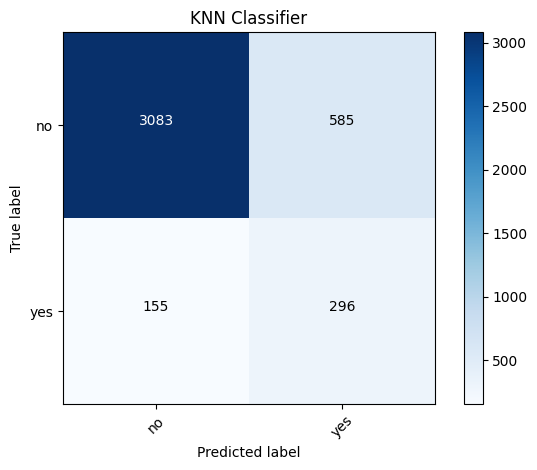

              precision    recall  f1-score   support

          no       0.95      0.84      0.89      3668
         yes       0.34      0.66      0.44       451

    accuracy                           0.82      4119
   macro avg       0.64      0.75      0.67      4119
weighted avg       0.88      0.82      0.84      4119


Best MultinomialNB Classifier with parameters({'classifier__alpha': 1.5, 'classifier__fit_prior': True}): Accuracy of 0.793396455450352 and cost 6920


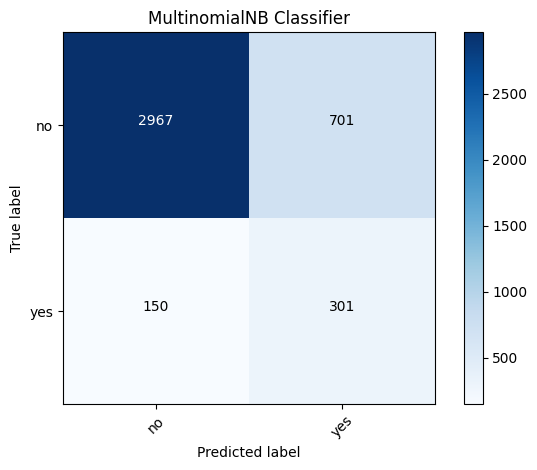

              precision    recall  f1-score   support

          no       0.95      0.81      0.87      3668
         yes       0.30      0.67      0.41       451

    accuracy                           0.79      4119
   macro avg       0.63      0.74      0.64      4119
weighted avg       0.88      0.79      0.82      4119


Best GaussianNB Classifier with parameters({'classifier__var_smoothing': 1.873817422860383e-06}): Accuracy of 0.8628307841709153 and cost 6820


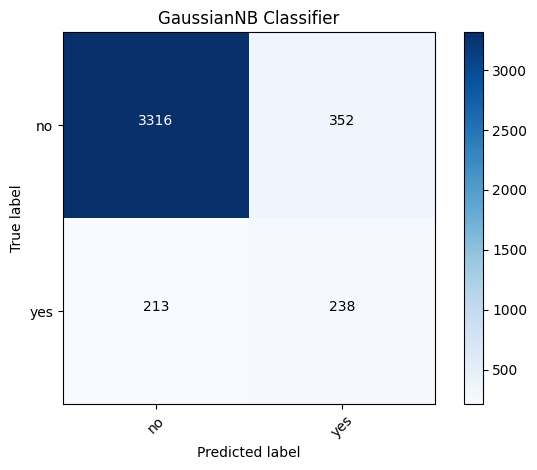

              precision    recall  f1-score   support

          no       0.94      0.90      0.92      3668
         yes       0.40      0.53      0.46       451

    accuracy                           0.86      4119
   macro avg       0.67      0.72      0.69      4119
weighted avg       0.88      0.86      0.87      4119



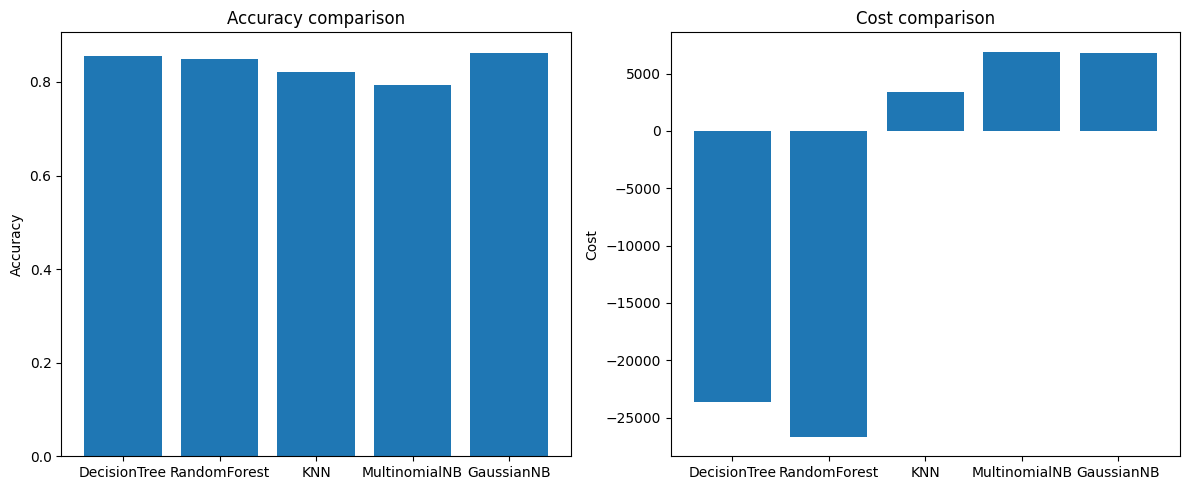

In [8]:
from sklearn.model_selection import GridSearchCV

# list of tuples where the first element is the classifier's name, the second is the classifier itself and the third are the grid search parameters
classifiers = [('DecisionTree', dt_pipeline, dt_param_grid),
               ('RandomForest', rf_pipeline, rf_param_grid),
               ('KNN', knn_pipeline, knn_param_grid),
               ('MultinomialNB', mnb_pipeline, mnb_param_grid),
               ('GaussianNB', gnb_pipeline, gnb_param_grid)]


# Initialize lists to store classifier names and their performances
names = []
accuracies = []
costs = []

# Loop over the classifiers
for name, pipeline, param_grid in classifiers:
    # Grid search with parameter grid and cost function
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=scorer)
    grid_search.fit(bank_data, bank_target)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Get the best parameters
    best_param = grid_search.best_params_
    
    # Make predictions with the best model
    prediction = best_model.predict(bank_data)

    # Calculate accuracy and cost
    cm = confusion_matrix(bank_target, prediction)
    acc = accuracy_score(bank_target, prediction)
    cost = cost_function(bank_target, prediction)

    # Append the name and performance metrics to the lists
    names.append(name)
    accuracies.append(acc)
    costs.append(cost)
    
    # Plot Confusion Matrix for each classifier
    print("\nBest {} Classifier with parameters({}): Accuracy of {} and cost {}".format(name, best_param, acc, cost))
    plot_confusion_matrix(cm, classes=label_names, title='{} Classifier'.format(name))
    plt.show()
    print(classification_report(bank_target, prediction, target_names=label_names))

# Plotting comparison
plt.figure(figsize=(12,5))

# Subplot for accuracy
plt.subplot(121)  # 1 row, 2 columns, plot 1
plt.bar(names, accuracies)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')

# Subplot for cost
plt.subplot(122)  # 1 row, 2 columns, plot 2
plt.bar(names, costs)
plt.title('Cost comparison')
plt.ylabel('Cost')

plt.tight_layout()
plt.show()